In [1]:
import torch
from torchvision import datasets, transforms

# Set the seed for reproducibility
torch.manual_seed(0)

# Define transformations for the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the data
])

# Download the CIFAR-10 dataset
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [2]:
selected_classes = [0, 1, 2]  # Airplane, Automobile, Bird

# Function to filter out classes
def filter_classes(dataset):
    indices = [i for i, (img, label) in enumerate(dataset) if label in selected_classes]
    return torch.utils.data.Subset(dataset, indices)

# Filter the train and test datasets
train_subset = filter_classes(cifar10_train)
test_subset = filter_classes(cifar10_test)


In [3]:
from torch.utils.data import DataLoader, random_split

# Split the subset for train and validation
train_size = int(0.8 * len(train_subset))
val_size = len(train_subset) - train_size
train_data, val_data = random_split(train_subset, [train_size, val_size])

# We assume that test_subset is already appropriately sized per your instruction


In [4]:
# Set batch size
batch_size = 64

# Create data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)


In [5]:
# Function to print the shape of datasets
def print_dataset_shapes(loader, name):
    images, labels = next(iter(loader))
    print(f"{name} dataset: images shape {images.shape}, labels shape {labels.shape}")

# Print the shapes for train, validation, and test datasets
print_dataset_shapes(train_loader, "Train")
print_dataset_shapes(val_loader, "Validation")
print_dataset_shapes(test_loader, "Test")


Train dataset: images shape torch.Size([64, 3, 32, 32]), labels shape torch.Size([64])
Validation dataset: images shape torch.Size([64, 3, 32, 32]), labels shape torch.Size([64])
Test dataset: images shape torch.Size([64, 3, 32, 32]), labels shape torch.Size([64])


In [6]:
# Verify total number of images in each DataLoader
def print_total_images(dataset, name):
    print(f"{name} dataset: Total images = {len(dataset)}")

# Print total number of images for each subset
print_total_images(train_data, "Train")
print_total_images(val_data, "Validation")
print_total_images(test_subset, "Test")


Train dataset: Total images = 12000
Validation dataset: Total images = 3000
Test dataset: Total images = 3000


**Part - 2**

In [7]:
import matplotlib.pyplot as plt

def extract_class_images(dataset, n_images, classes):
    images_per_class = {class_label: [] for class_label in classes}
    class_counts = {class_label: 0 for class_label in classes}

    # Iterate over the dataset and collect images
    for image, label in dataset:
        if class_counts[label] < n_images:
            images_per_class[label].append(image)
            class_counts[label] += 1
        if all(count == n_images for count in class_counts.values()):
            break
    return images_per_class


In [8]:
def plot_images(images_per_class, classes):
    fig, axs = plt.subplots(len(classes), n_images, figsize=(15, 8))
    class_names = ['Airplane', 'Automobile', 'Bird']  # Class names corresponding to selected classes

    for idx, class_label in enumerate(classes):
        for img_idx, img in enumerate(images_per_class[class_label]):
            ax = axs[idx, img_idx]
            img = img.permute(1, 2, 0)  # Change from CxHxW to HxWxC
            ax.imshow(img.numpy() * 0.5 + 0.5)  # Unnormalize the image
            ax.axis('off')
            if img_idx == 0:
                ax.set_title(class_names[idx])

    plt.show()


Training Dataset Images:


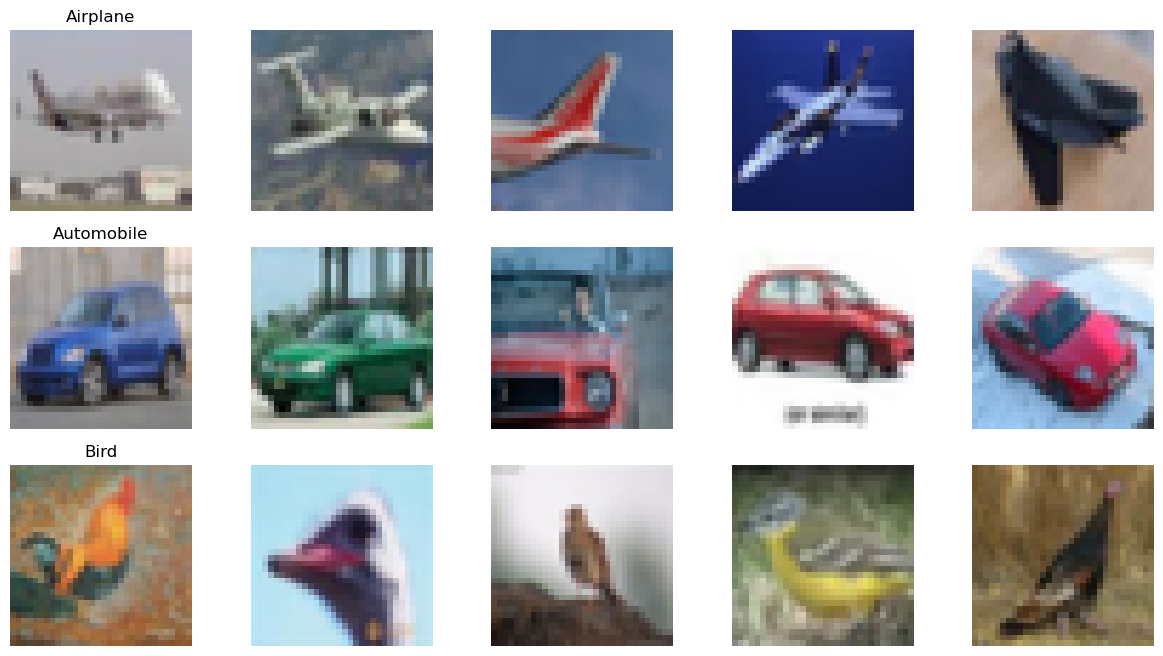

Validation Dataset Images:


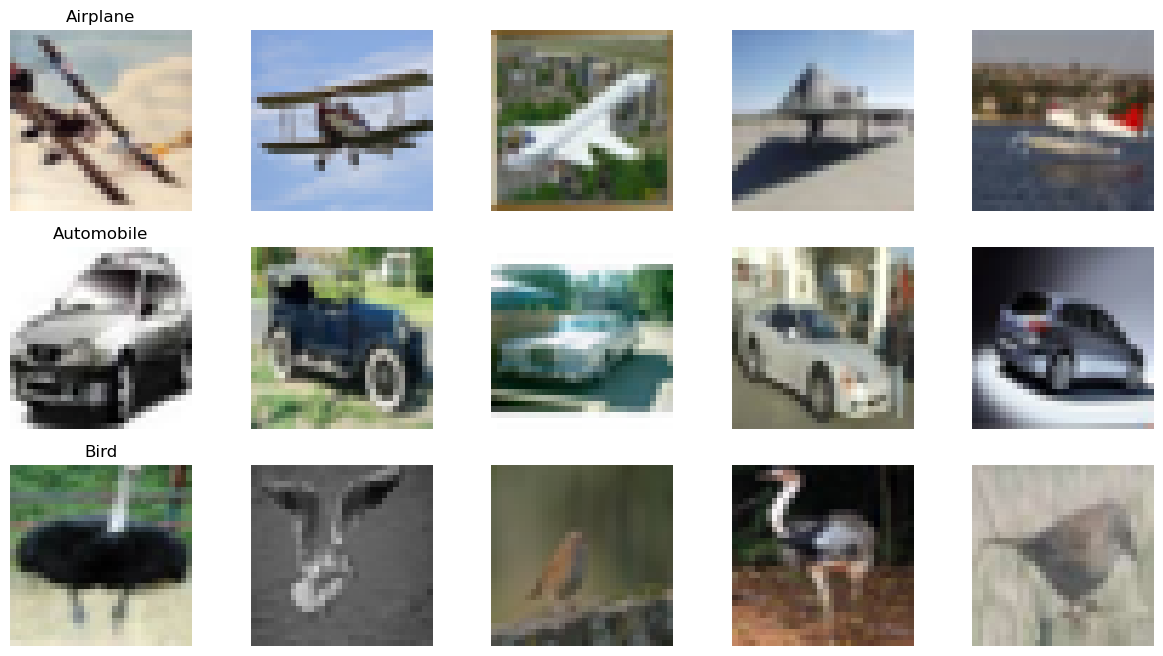

In [9]:
# Define the number of images per class and the classes you're interested in
n_images = 5
classes = [0, 1, 2]  # Airplane, Automobile, Bird

# Extract and plot images from the training dataset
train_images_per_class = extract_class_images(train_loader.dataset, n_images, classes)
print("Training Dataset Images:")
plot_images(train_images_per_class, classes)

# Extract and plot images from the validation dataset
val_images_per_class = extract_class_images(val_loader.dataset, n_images, classes)
print("Validation Dataset Images:")
plot_images(val_images_per_class, classes)


**Part - 3**

In [54]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, 16)
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.fc2 = nn.Linear(16, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Applying dropout
        x = self.fc2(x)
        return x

# class SimpleCNN(nn.Module):
#     def __init__(self, num_classes=3):  # Assuming 3 classes as per your previous filter setup
#         super(SimpleCNN, self).__init__()
#         # First convolutional layer
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=1)
#         # First max-pooling layer
#         self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        
#         # Second convolutional layer
#         self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
#         # Second max-pooling layer
#         self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
        
#         # Flatten layer
#         self.flatten = nn.Flatten()

#         # Fully connected layers / MLP
#         # self.fc1 = nn.Linear(32 * 2 * 2, 16)  # Adjusted the size based on the output of the second pool
#         self.fc1 = nn.Linear(512, 16)
#         self.fc2 = nn.Linear(16, num_classes)  # Final classification layer
        
#     def forward(self, x):
#         # Applying the first convolution and pooling layers
#         x = self.pool1(F.relu(self.conv1(x)))
#         # Applying the second convolution and pooling layers
#         x = self.pool2(F.relu(self.conv2(x)))
#         # Flatten the output from the convolutional layers to input into the MLP
#         x = self.flatten(x)
#         # Passing through the first fully connected layer
#         x = F.relu(self.fc1(x))
#         # Output layer
#         x = self.fc2(x)
#         return x


In [55]:
from torchsummary import summary

# Assuming using CIFAR-10 image size (32x32) and RGB (3 channels)
model = SimpleCNN(num_classes=3)
print(model)

# Summary (if you have torchsummary installed)
summary(model, input_size=(3, 32, 32))


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=512, out_features=16, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=16, out_features=3, bias=True)
)
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            1,216
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            4,640
├─MaxPool2d: 1-4                         --
├─Flatten: 1-5                           --
├─Linear: 1-6                            8,208
├─Dropout: 1-7                           --
├─Linear: 1-8                            51
Total params: 14,115
Trainable params: 14,115
Non-trainable

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            1,216
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            4,640
├─MaxPool2d: 1-4                         --
├─Flatten: 1-5                           --
├─Linear: 1-6                            8,208
├─Dropout: 1-7                           --
├─Linear: 1-8                            51
Total params: 14,115
Trainable params: 14,115
Non-trainable params: 0

**Training**

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Model Initialization
model = SimpleCNN(num_classes=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [57]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).float().sum()
    accuracy = correct / labels.size(0)
    return accuracy.item()  # Convert from tensor to Python float


def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    total_accuracy = 0.0
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        total_accuracy += calculate_accuracy(outputs, labels)
    
    return running_loss / len(train_loader), total_accuracy / len(train_loader)

def validate(model, val_loader, criterion, device):
    model.eval()
    validation_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            total_accuracy += calculate_accuracy(outputs, labels)
            
    return validation_loss / len(val_loader), total_accuracy / len(val_loader)


In [58]:
# epochs = 15

# for epoch in range(epochs):
#     train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, criterion, device)
#     val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    
#     print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
    
#     # Save model after each epoch
#     torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')


import matplotlib.pyplot as plt

epochs = 15
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)  # These should now be Python floats
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)  # These should now be Python floats
    
    print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
    
    torch.save(model.state_dict(), f'models/model_epoch_{epoch+1}.pth')



Epoch 1/15 - Train Loss: 0.8275, Train Acc: 0.6359, Val Loss: 0.6003, Val Acc: 0.7711
Epoch 2/15 - Train Loss: 0.6570, Train Acc: 0.7379, Val Loss: 0.5276, Val Acc: 0.7951
Epoch 3/15 - Train Loss: 0.5980, Train Acc: 0.7589, Val Loss: 0.4699, Val Acc: 0.8097
Epoch 4/15 - Train Loss: 0.5525, Train Acc: 0.7788, Val Loss: 0.4633, Val Acc: 0.8250
Epoch 5/15 - Train Loss: 0.5123, Train Acc: 0.7918, Val Loss: 0.4286, Val Acc: 0.8447
Epoch 6/15 - Train Loss: 0.4856, Train Acc: 0.8051, Val Loss: 0.3817, Val Acc: 0.8584
Epoch 7/15 - Train Loss: 0.4711, Train Acc: 0.8142, Val Loss: 0.3785, Val Acc: 0.8577
Epoch 8/15 - Train Loss: 0.4439, Train Acc: 0.8219, Val Loss: 0.4429, Val Acc: 0.8200
Epoch 9/15 - Train Loss: 0.4397, Train Acc: 0.8286, Val Loss: 0.3482, Val Acc: 0.8666
Epoch 10/15 - Train Loss: 0.4286, Train Acc: 0.8327, Val Loss: 0.3485, Val Acc: 0.8643
Epoch 11/15 - Train Loss: 0.4181, Train Acc: 0.8368, Val Loss: 0.3684, Val Acc: 0.8624
Epoch 12/15 - Train Loss: 0.4021, Train Acc: 0.8438,

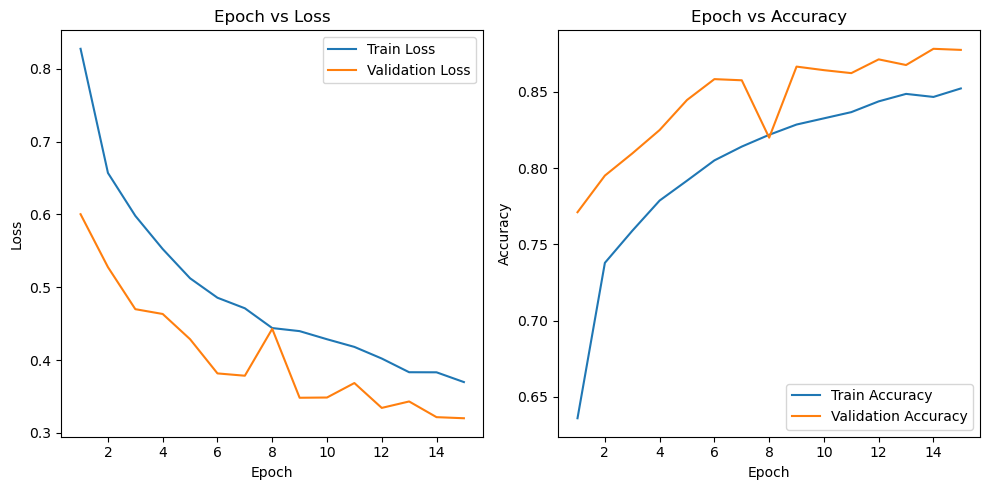

In [59]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


**Part - 5**

In [64]:
def evaluate_model_on_validation(model, val_loader, device, criterion):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            total_accuracy += calculate_accuracy(outputs, labels)

    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_accuracy / len(val_loader)
    return avg_loss, avg_accuracy

best_model_path = ''
best_accuracy = 0

for epoch in range(1, 16):  # Assuming you have saved 15 models
    model_path = f'models/model_epoch_{epoch}.pth'
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    _, val_accuracy = evaluate_model_on_validation(model, val_loader, device, criterion)
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model_path = model_path

print(f'Best Model Path: {best_model_path} with Validation Accuracy: {best_accuracy:.4f}')


/tmp/ipykernel_38431/3566573525.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Best Model Path: models/model_epoch_14.pth with Validation Accuracy: 0.8783


In [65]:
# Load the best model
model.load_state_dict(torch.load(best_model_path))
model.to(device)

# Evaluate on test data
test_labels, test_preds = test_model(model, test_loader, device)

# Calculate accuracy and F1-score
test_accuracy = accuracy_score(test_labels, test_preds)
test_f1_score = f1_score(test_labels, test_preds, average='macro')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1 Score: {test_f1_score:.4f}')


/tmp/ipykernel_38431/3543668247.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Accuracy: 0.8863
Test F1 Score: 0.8865


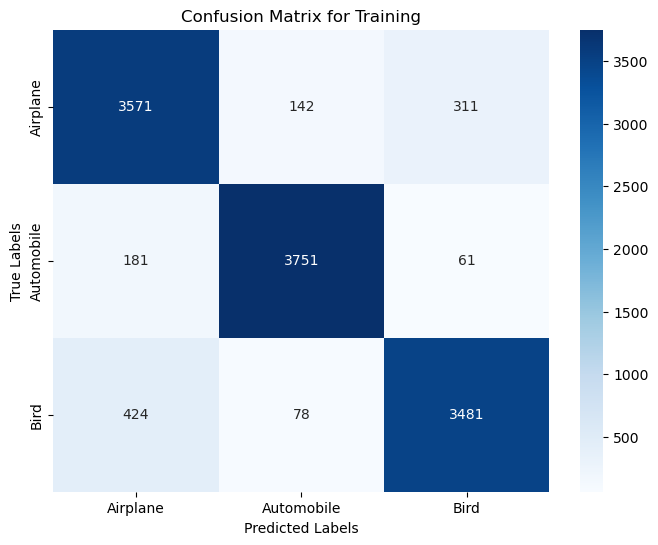

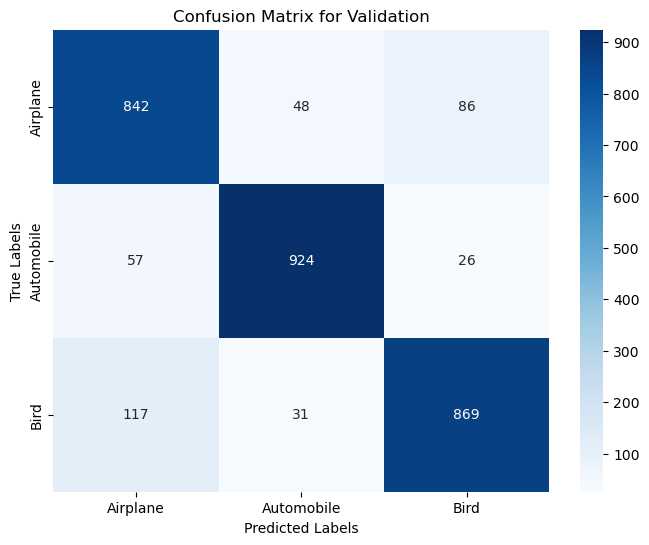

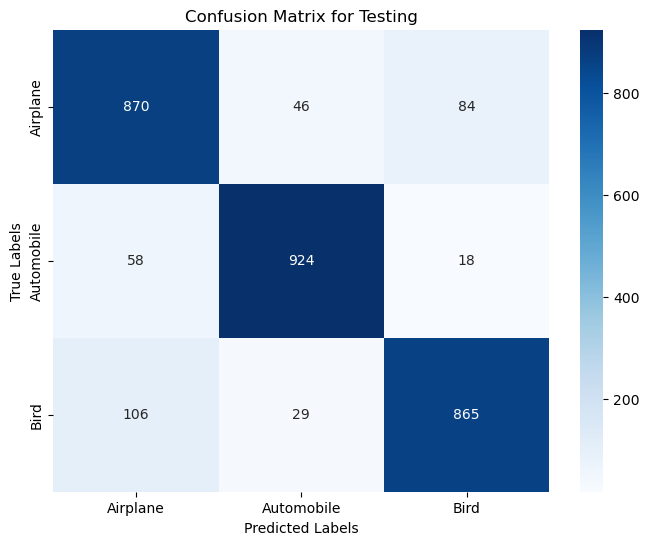

In [66]:
# Assuming the functions are already defined

def plot_confusion_matrix(labels, preds, classes, dataset_type):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {dataset_type}')
    plt.show()


train_labels, train_preds = test_model(model, train_loader, device)
val_labels, val_preds = test_model(model, val_loader, device)
test_labels, test_preds = test_model(model, test_loader, device)

# Class names as per your dataset classes
class_names = ['Airplane', 'Automobile', 'Bird']  # Example class names

# Plot confusion matrices with clear labels
plot_confusion_matrix(train_labels, train_preds, class_names, "Training")
plot_confusion_matrix(val_labels, val_preds, class_names, "Validation")
plot_confusion_matrix(test_labels, test_preds, class_names, "Testing")


**Part - 6**

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim


class MLP(nn.Module):
    def __init__(self, num_classes=3):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*32*3, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Add dropout with a probability of 0.5
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout after the activation
        x = self.fc2(x)
        return x


In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_accuracy += calculate_accuracy(outputs, labels)
    
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader)
    return avg_loss, avg_accuracy

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            total_accuracy += calculate_accuracy(outputs, labels)
            
    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_accuracy / len(val_loader)
    return avg_loss, avg_accuracy


In [69]:
epochs = 15
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    
    # Save model after each epoch
    torch.save(model.state_dict(), f'mlp_models/mlp_model_epoch_{epoch+1}.pth')


Epoch 1/15: Train Loss: 0.7712, Train Accuracy: 0.6896, Validation Loss: 0.6667, Validation Accuracy: 0.7267
Epoch 2/15: Train Loss: 0.6733, Train Accuracy: 0.7259, Validation Loss: 0.6416, Validation Accuracy: 0.7453
Epoch 3/15: Train Loss: 0.6466, Train Accuracy: 0.7454, Validation Loss: 0.6051, Validation Accuracy: 0.7586
Epoch 4/15: Train Loss: 0.6313, Train Accuracy: 0.7495, Validation Loss: 0.5965, Validation Accuracy: 0.7537
Epoch 5/15: Train Loss: 0.6178, Train Accuracy: 0.7612, Validation Loss: 0.5914, Validation Accuracy: 0.7653
Epoch 6/15: Train Loss: 0.5920, Train Accuracy: 0.7675, Validation Loss: 0.5888, Validation Accuracy: 0.7621
Epoch 7/15: Train Loss: 0.5910, Train Accuracy: 0.7685, Validation Loss: 0.5780, Validation Accuracy: 0.7694
Epoch 8/15: Train Loss: 0.5800, Train Accuracy: 0.7709, Validation Loss: 0.5714, Validation Accuracy: 0.7686
Epoch 9/15: Train Loss: 0.5674, Train Accuracy: 0.7775, Validation Loss: 0.5743, Validation Accuracy: 0.7750
Epoch 10/15: Train 

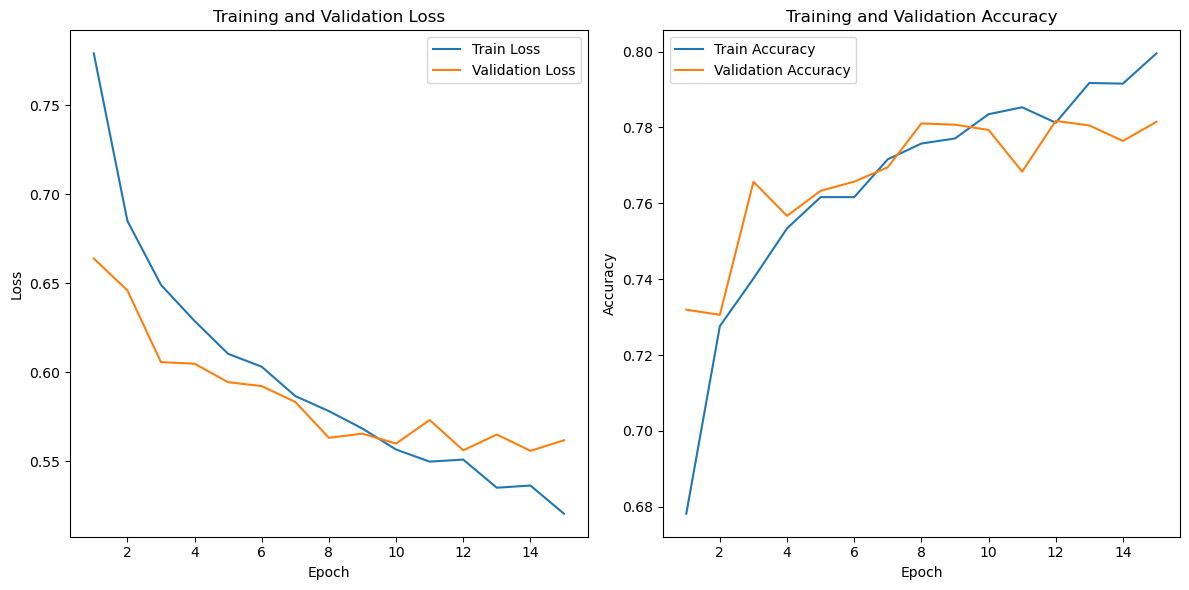

In [51]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [73]:
#** Part - 7 **



def evaluate_model_on_validation(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            total_accuracy += calculate_accuracy(outputs, labels)

    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_accuracy / len(val_loader)
    return avg_loss, avg_accuracy

best_val_accuracy = 0
best_epoch = 0

# Load each saved model and evaluate it on the validation set
for epoch in range(1, 16):  # Assuming you saved models for 15 epochs
    model_path = f'mlp_models/mlp_model_epoch_{epoch}.pth'
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    _, val_accuracy = evaluate_model_on_validation(model, val_loader, criterion, device)
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch

best_mlp_model_path = f'mlp_models/mlp_model_epoch_{best_epoch}.pth'
print(f'Best MLP Model: Epoch {best_epoch} with Validation Accuracy: {best_val_accuracy:.4f}')


/tmp/ipykernel_38431/3268817859.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Best MLP Model: Epoch 15 with Validation Accuracy: 0.7835


/tmp/ipykernel_38431/2709487491.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_mlp_model_path))


MLP Test Accuracy: 0.7963
MLP Test F1 Score: 0.7964


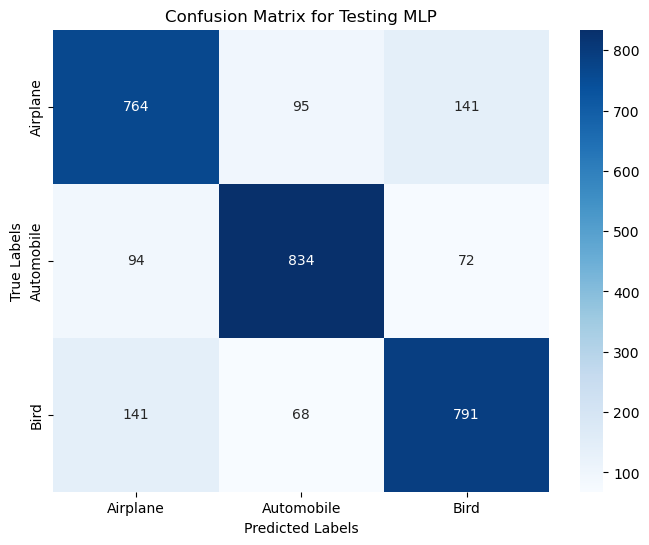

In [74]:
# Load the best MLP model
model.load_state_dict(torch.load(best_mlp_model_path))
model.to(device)

# Evaluate on test data
test_labels, test_preds = test_model(model, test_loader, device)

# Calculate accuracy and F1-score
mlp_test_accuracy = accuracy_score(test_labels, test_preds)
mlp_test_f1_score = f1_score(test_labels, test_preds, average='macro')
print(f'MLP Test Accuracy: {mlp_test_accuracy:.4f}')
print(f'MLP Test F1 Score: {mlp_test_f1_score:.4f}')

# Plot the confusion matrix
plot_confusion_matrix(test_labels, test_preds, class_names, "Testing MLP")


In [ ]:
# Hypothetical results from CNN for comparison
cnn_test_accuracy = 0.85  # Example
cnn_test_f1_score = 0.84  # Example

print("Comparison Results:")
print(f"Accuracy - CNN: {cnn_test_accuracy:.4f}, MLP: {mlp_test_accuracy:.4f}")
print(f"F1 Score - CNN: {cnn_test_f1_score:.4f}, MLP: {mlp_test_f1_score:.4f}")

# Assuming confusion matrices are plotted within the respective functions


Comparison Results:
Accuracy - CNN: 0.8500, MLP: 0.7963
F1 Score - CNN: 0.8400, MLP: 0.7964


: 